# Trabalho 3 - Aprendizado por Reforço
## Treinamento de Agente no Ambiente CarRacing-v3

**Disciplina:** Inteligência Artificial - 2025/2  
**Professor:** Sérgio Nery Simões  
**Instituição:** IFES - Instituto Federal do Espírito Santo

---

### Objetivo
Treinar um agente utilizando PPO (Proximal Policy Optimization) para solucionar o ambiente CarRacing-v3 em três configurações: 250K, 500K e 750K timesteps.

## 1. Instalação de Dependências

Execute o seguinte comando no terminal Ubuntu:
```bash
pip install gymnasium[box2d] stable-baselines3[extra] tensorboard imageio imageio-ffmpeg matplotlib seaborn pandas
```

In [1]:
# Importações necessárias
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor
import os
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Configuração Inicial

In [2]:
# Configurações globais
TRAINING_CONFIGS = [250_000, 500_000, 750_000]  # Timesteps
MODEL_DIR = "modelos_salvos"
VIDEO_DIR = "videos_agentes"
LOG_DIR = "logs"

# Criar diretórios
for directory in [MODEL_DIR, VIDEO_DIR, LOG_DIR]:
    os.makedirs(directory, exist_ok=True)
    print(f"✓ Diretório criado/verificado: {directory}")

# Verificar se o ambiente está disponível
try:
    test_env = gym.make('CarRacing-v3')
    test_env.close()
    print("\n✓ Ambiente CarRacing-v3 disponível e funcionando!")
except Exception as e:
    print(f"\n✗ Erro ao carregar ambiente: {e}")

✓ Diretório criado/verificado: modelos_salvos
✓ Diretório criado/verificado: videos_agentes
✓ Diretório criado/verificado: logs

✓ Ambiente CarRacing-v3 disponível e funcionando!


## 3. Funções Auxiliares

In [3]:
def create_env():
    """Cria e configura o ambiente CarRacing-v3"""
    env = gym.make('CarRacing-v3', render_mode='rgb_array', continuous=True)
    env = Monitor(env)
    return env


def train_agent(total_timesteps, run_name):
    """
    Treina o agente PPO
    
    Args:
        total_timesteps: Número total de passos de treinamento
        run_name: Nome para salvar o modelo
    
    Returns:
        Caminho do modelo salvo
    """
    print(f"\n{'='*60}")
    print(f"Iniciando treinamento: {run_name}")
    print(f"Timesteps: {total_timesteps:,}")
    print(f"{'='*60}\n")
    
    # Criar ambiente
    env = DummyVecEnv([create_env])
    
    # Configuração do modelo PPO
    model = PPO(
        "CnnPolicy",
        env,
        learning_rate=3e-4,
        n_steps=512,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=1,
        tensorboard_log=f"{LOG_DIR}/{run_name}"
    )
    
    # Callback para salvar checkpoints
    checkpoint_callback = CheckpointCallback(
        save_freq=50_000,
        save_path=f"{MODEL_DIR}/{run_name}_checkpoints",
        name_prefix="ppo_carracing"
    )
    
    # Treinar
    start_time = datetime.now()
    model.learn(
        total_timesteps=total_timesteps,
        callback=checkpoint_callback,
        progress_bar=True
    )
    end_time = datetime.now()
    
    # Salvar modelo final
    model_path = f"{MODEL_DIR}/ppo_carracing_{run_name}.zip"
    model.save(model_path)
    
    training_time = (end_time - start_time).total_seconds() / 60
    print(f"\n✓ Treinamento concluído em {training_time:.2f} minutos")
    print(f"✓ Modelo salvo em: {model_path}\n")
    
    env.close()
    return model_path


def evaluate_agent(model_path, num_episodes=5):
    """
    Avalia o agente treinado
    
    Args:
        model_path: Caminho do modelo salvo
        num_episodes: Número de episódios para avaliação
    
    Returns:
        Lista de recompensas totais
    """
    print(f"Avaliando modelo: {model_path}")
    
    env = gym.make('CarRacing-v3', render_mode='rgb_array', continuous=True)
    model = PPO.load(model_path)
    
    episode_rewards = []
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        total_reward = 0
        done = False
        truncated = False
        steps = 0
        
        while not (done or truncated):
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            steps += 1
        
        episode_rewards.append(total_reward)
        print(f"  Episódio {episode+1}: Recompensa = {total_reward:.2f}, Passos = {steps}")
    
    env.close()
    
    avg_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    print(f"\n✓ Recompensa Média: {avg_reward:.2f} ± {std_reward:.2f}\n")
    
    return episode_rewards


def generate_video(model_path, video_name, max_steps=1000):
    """
    Gera vídeo do agente em ação
    
    Args:
        model_path: Caminho do modelo salvo
        video_name: Nome do arquivo de vídeo
        max_steps: Máximo de passos a gravar
    
    Returns:
        Caminho do vídeo e recompensa total
    """
    print(f"Gerando vídeo: {video_name}")
    
    env = gym.make('CarRacing-v3', render_mode='rgb_array', continuous=True)
    model = PPO.load(model_path)
    
    frames = []
    obs, info = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        frame = env.render()
        frames.append(frame)
        
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        
        if done or truncated:
            break
    
    env.close()
    
    # Salvar vídeo
    video_path = f"{VIDEO_DIR}/{video_name}"
    imageio.mimsave(video_path, frames, fps=30)
    
    print(f"✓ Vídeo salvo: {video_path}")
    print(f"  Recompensa total: {total_reward:.2f}")
    print(f"  Frames gravados: {len(frames)}\n")
    
    return video_path, total_reward


print("✓ Funções auxiliares definidas com sucesso!")

✓ Funções auxiliares definidas com sucesso!


## 4. Treinamento dos Modelos

### ⚠️ ATENÇÃO: Esta célula pode levar várias horas para executar!

Tempos estimados (com GPU):
- 250K passos: ~45-60 minutos
- 500K passos: ~90-120 minutos  
- 750K passos: ~135-180 minutos

**Total estimado: 4-6 horas**

In [4]:
# Dicionário para armazenar resultados
results = {}

print("\n" + "="*60)
print("INICIANDO PIPELINE COMPLETO DE TREINAMENTO")
print("="*60 + "\n")

# Loop através das configurações
for timesteps in TRAINING_CONFIGS:
    run_name = f"{timesteps//1000}K"
    
    # 1. Treinar
    model_path = train_agent(timesteps, run_name)
    
    # 2. Avaliar
    rewards = evaluate_agent(model_path, num_episodes=5)
    
    # 3. Gerar vídeo
    video_path, video_reward = generate_video(
        model_path, 
        f"carracing_{run_name}.mp4",
        max_steps=1000
    )
    
    # Armazenar resultados
    results[run_name] = {
        'model_path': model_path,
        'video_path': video_path,
        'eval_rewards': rewards,
        'video_reward': video_reward,
        'avg_reward': np.mean(rewards),
        'std_reward': np.std(rewards)
    }
    
    print(f"{'='*60}\n")

print("\n✓ TREINAMENTO COMPLETO!\n")


INICIANDO PIPELINE COMPLETO DE TREINAMENTO


Iniciando treinamento: 250K
Timesteps: 250,000

Using cuda device
Wrapping the env in a VecTransposeImage.


Logging to logs/250K/PPO_4


Output()

----------------------------
| time/              |     |
|    fps             | 126 |
|    iterations      | 1   |
|    time_elapsed    | 4   |
|    total_timesteps | 512 |
----------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -57         |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.010358686 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | -0.0108     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.169       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0153     |
|    std                  | 1           |
|    value_loss           | 0.591       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -57         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 3           |
|    time_elapsed         | 12          |
|    total_timesteps      | 1536        |
| train/                  |             |
|    approx_kl            | 0.009803441 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | 0.233       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0417      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0106     |
|    std                  | 0.998       |
|    value_loss           | 0.668       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -53.5       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 4           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008388123 |
|    clip_fraction        | 0.0932      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |
|    explained_variance   | -0.15       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.688       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00486    |
|    std                  | 0.998       |
|    value_loss           | 0.879       |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -53.5        |
| time/                   |              |
|    fps                  | 120          |
|    iterations           | 5            |
|    time_elapsed         | 21           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0063780006 |
|    clip_fraction        | 0.119        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0.0653       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0142      |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.012       |
|    std                  | 0.997        |
|    value_loss           | 0.536        |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -56.2       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 6           |
|    time_elapsed         | 25          |
|    total_timesteps      | 3072        |
| train/                  |             |
|    approx_kl            | 0.007202792 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | 0.275       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.135       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0136     |
|    std                  | 0.992       |
|    value_loss           | 0.752       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -56.2       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 7           |
|    time_elapsed         | 29          |
|    total_timesteps      | 3584        |
| train/                  |             |
|    approx_kl            | 0.016154032 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.23       |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0533     |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0115     |
|    std                  | 0.991       |
|    value_loss           | 0.119       |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -56.4      |
| time/                   |            |
|    fps                  | 119        |
|    iterations           | 8          |
|    time_elapsed         | 34         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00935298 |
|    clip_fraction        | 0.157      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.22      |
|    explained_variance   | 0.46       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.186      |
|    n_updates            | 70         |
|    policy_gradient_loss | -0.0157    |
|    std                  | 0.986      |
|    value_loss           | 0.565      |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -56.4       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 9           |
|    time_elapsed         | 38          |
|    total_timesteps      | 4608        |
| train/                  |             |
|    approx_kl            | 0.012717797 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.21       |
|    explained_variance   | 0.744       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0569     |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0176     |
|    std                  | 0.978       |
|    value_loss           | 0.101       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -48.3       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 10          |
|    time_elapsed         | 43          |
|    total_timesteps      | 5120        |
| train/                  |             |
|    approx_kl            | 0.008543603 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.19       |
|    explained_variance   | 0.016       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.211       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0086     |
|    std                  | 0.975       |
|    value_loss           | 0.652       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -48.3       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 11          |
|    time_elapsed         | 47          |
|    total_timesteps      | 5632        |
| train/                  |             |
|    approx_kl            | 0.015886122 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.18       |
|    explained_variance   | 0.154       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.113       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0142     |
|    std                  | 0.972       |
|    value_loss           | 0.594       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -46.9       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 12          |
|    time_elapsed         | 51          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.012227243 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | -0.311      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.152       |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0146     |
|    std                  | 0.971       |
|    value_loss           | 0.535       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -46.9       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 13          |
|    time_elapsed         | 56          |
|    total_timesteps      | 6656        |
| train/                  |             |
|    approx_kl            | 0.010180326 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 0.0846      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00933    |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00974    |
|    std                  | 0.972       |
|    value_loss           | 0.434       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -45.7       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 14          |
|    time_elapsed         | 60          |
|    total_timesteps      | 7168        |
| train/                  |             |
|    approx_kl            | 0.010377433 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | -0.388      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0286      |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0124     |
|    std                  | 0.97        |
|    value_loss           | 0.337       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -45.7       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 15          |
|    time_elapsed         | 65          |
|    total_timesteps      | 7680        |
| train/                  |             |
|    approx_kl            | 0.015170053 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 0.183       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.17        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0163     |
|    std                  | 0.972       |
|    value_loss           | 0.612       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -49         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 16          |
|    time_elapsed         | 69          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010625746 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 0.497       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0632     |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0168     |
|    std                  | 0.972       |
|    value_loss           | 0.0852      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -49         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 17          |
|    time_elapsed         | 74          |
|    total_timesteps      | 8704        |
| train/                  |             |
|    approx_kl            | 0.015663924 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 0.533       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.133       |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0175     |
|    std                  | 0.973       |
|    value_loss           | 0.515       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -49.2       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 18          |
|    time_elapsed         | 78          |
|    total_timesteps      | 9216        |
| train/                  |             |
|    approx_kl            | 0.019178674 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 0.247       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0151      |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.015      |
|    std                  | 0.974       |
|    value_loss           | 0.228       |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | -49.2     |
| time/                   |           |
|    fps                  | 117       |
|    iterations           | 19        |
|    time_elapsed         | 82        |
|    total_timesteps      | 9728      |
| train/                  |           |
|    approx_kl            | 0.0174713 |
|    clip_fraction        | 0.175     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.17     |
|    explained_variance   | 0.599     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0424    |
|    n_updates            | 180       |
|    policy_gradient_loss | -0.0207   |
|    std                  | 0.972     |
|    value_loss           | 0.335     |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -50.4        |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 20           |
|    time_elapsed         | 87           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0068715326 |
|    clip_fraction        | 0.204        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.16        |
|    explained_variance   | 0.599        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0536      |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.0196      |
|    std                  | 0.967        |
|    value_loss           | 0.199        |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -50.4       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 21          |
|    time_elapsed         | 91          |
|    total_timesteps      | 10752       |
| train/                  |             |
|    approx_kl            | 0.008227307 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.719       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.172       |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0134     |
|    std                  | 0.963       |
|    value_loss           | 0.447       |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -47.9      |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 22         |
|    time_elapsed         | 95         |
|    total_timesteps      | 11264      |
| train/                  |            |
|    approx_kl            | 0.01696389 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.14      |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.111      |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.0208    |
|    std                  | 0.963      |
|    value_loss           | 0.514      |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -47.9        |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 23           |
|    time_elapsed         | 99           |
|    total_timesteps      | 11776        |
| train/                  |              |
|    approx_kl            | 0.0120552145 |
|    clip_fraction        | 0.152        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.14        |
|    explained_variance   | 0.901        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0888       |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.0132      |
|    std                  | 0.966        |
|    value_loss           | 0.532        |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -46.9       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 24          |
|    time_elapsed         | 104         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.016052732 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0192      |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0203     |
|    std                  | 0.967       |
|    value_loss           | 0.253       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -46.9       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 25          |
|    time_elapsed         | 108         |
|    total_timesteps      | 12800       |
| train/                  |             |
|    approx_kl            | 0.015777828 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0148      |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0197     |
|    std                  | 0.965       |
|    value_loss           | 0.23        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -48.7        |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 26           |
|    time_elapsed         | 112          |
|    total_timesteps      | 13312        |
| train/                  |              |
|    approx_kl            | 0.0076280246 |
|    clip_fraction        | 0.16         |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.13        |
|    explained_variance   | 0.814        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0574      |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00982     |
|    std                  | 0.953        |
|    value_loss           | 0.0271       |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -48.7       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 27          |
|    time_elapsed         | 117         |
|    total_timesteps      | 13824       |
| train/                  |             |
|    approx_kl            | 0.011569491 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.11       |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00514     |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0254     |
|    std                  | 0.953       |
|    value_loss           | 0.201       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -50.8       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 28          |
|    time_elapsed         | 121         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.012952173 |
|    clip_fraction        | 0.0953      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.11       |
|    explained_variance   | 0.693       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0325     |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00322    |
|    std                  | 0.952       |
|    value_loss           | 0.0234      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -50.8       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 29          |
|    time_elapsed         | 125         |
|    total_timesteps      | 14848       |
| train/                  |             |
|    approx_kl            | 0.013853526 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.1        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0675      |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0226     |
|    std                  | 0.951       |
|    value_loss           | 0.379       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -46         |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 30          |
|    time_elapsed         | 130         |
|    total_timesteps      | 15360       |
| train/                  |             |
|    approx_kl            | 0.012656879 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.1        |
|    explained_variance   | 0.598       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.139       |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.948       |
|    value_loss           | 0.775       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -46         |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 31          |
|    time_elapsed         | 134         |
|    total_timesteps      | 15872       |
| train/                  |             |
|    approx_kl            | 0.016100097 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.09       |
|    explained_variance   | 0.551       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.111       |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0131     |
|    std                  | 0.945       |
|    value_loss           | 0.753       |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -42.1      |
| time/                   |            |
|    fps                  | 118        |
|    iterations           | 32         |
|    time_elapsed         | 138        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.02278494 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.08      |
|    explained_variance   | 0.177      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.233      |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.0131    |
|    std                  | 0.941      |
|    value_loss           | 0.917      |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -42.1       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 33          |
|    time_elapsed         | 142         |
|    total_timesteps      | 16896       |
| train/                  |             |
|    approx_kl            | 0.016291792 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.07       |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0626      |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.022      |
|    std                  | 0.937       |
|    value_loss           | 1.34        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -41.1       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 34          |
|    time_elapsed         | 147         |
|    total_timesteps      | 17408       |
| train/                  |             |
|    approx_kl            | 0.011388298 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.06       |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.055      |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.00119    |
|    std                  | 0.939       |
|    value_loss           | 0.0909      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -41.1       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 35          |
|    time_elapsed         | 151         |
|    total_timesteps      | 17920       |
| train/                  |             |
|    approx_kl            | 0.013296662 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.06       |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0692      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0154     |
|    std                  | 0.938       |
|    value_loss           | 0.524       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -36.1       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 36          |
|    time_elapsed         | 156         |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.009342305 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.06       |
|    explained_variance   | 0.564       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.207       |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0201     |
|    std                  | 0.936       |
|    value_loss           | 1.11        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -36.1       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 37          |
|    time_elapsed         | 160         |
|    total_timesteps      | 18944       |
| train/                  |             |
|    approx_kl            | 0.021355182 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.05       |
|    explained_variance   | 0.539       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.199       |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.0272     |
|    std                  | 0.935       |
|    value_loss           | 1.14        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -31         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 38          |
|    time_elapsed         | 164         |
|    total_timesteps      | 19456       |
| train/                  |             |
|    approx_kl            | 0.013463844 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.05       |
|    explained_variance   | 0.472       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.204       |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.0158     |
|    std                  | 0.936       |
|    value_loss           | 1.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -31         |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 39          |
|    time_elapsed         | 169         |
|    total_timesteps      | 19968       |
| train/                  |             |
|    approx_kl            | 0.017689062 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.05       |
|    explained_variance   | 0.391       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.191       |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.0263     |
|    std                  | 0.933       |
|    value_loss           | 1.2         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -25.7       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 40          |
|    time_elapsed         | 173         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.027132701 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.04       |
|    explained_variance   | 0.0294      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.462       |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0045     |
|    std                  | 0.933       |
|    value_loss           | 1.35        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -25.7       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 41          |
|    time_elapsed         | 177         |
|    total_timesteps      | 20992       |
| train/                  |             |
|    approx_kl            | 0.015750848 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.04       |
|    explained_variance   | 0.703       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0532      |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0137     |
|    std                  | 0.93        |
|    value_loss           | 0.822       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -25.3       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 42          |
|    time_elapsed         | 182         |
|    total_timesteps      | 21504       |
| train/                  |             |
|    approx_kl            | 0.013648472 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.02       |
|    explained_variance   | 0.818       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0268     |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00858    |
|    std                  | 0.92        |
|    value_loss           | 0.126       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -21.5       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 43          |
|    time_elapsed         | 186         |
|    total_timesteps      | 22016       |
| train/                  |             |
|    approx_kl            | 0.019822676 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.99       |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.19        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.018      |
|    std                  | 0.917       |
|    value_loss           | 1.22        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -21.5       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 44          |
|    time_elapsed         | 191         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.011942448 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.99       |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.563       |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0114     |
|    std                  | 0.919       |
|    value_loss           | 1.11        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -18         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 45          |
|    time_elapsed         | 195         |
|    total_timesteps      | 23040       |
| train/                  |             |
|    approx_kl            | 0.022175163 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.99       |
|    explained_variance   | 0.15        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.232       |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.0145     |
|    std                  | 0.916       |
|    value_loss           | 0.833       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -18         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 46          |
|    time_elapsed         | 199         |
|    total_timesteps      | 23552       |
| train/                  |             |
|    approx_kl            | 0.009985564 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.98       |
|    explained_variance   | 0.0346      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.294       |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.0167     |
|    std                  | 0.912       |
|    value_loss           | 1.17        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -14.1       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 47          |
|    time_elapsed         | 204         |
|    total_timesteps      | 24064       |
| train/                  |             |
|    approx_kl            | 0.019993287 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.96       |
|    explained_variance   | 0.152       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.252       |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0168     |
|    std                  | 0.907       |
|    value_loss           | 0.927       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -14.1       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 48          |
|    time_elapsed         | 208         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.018088445 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.95       |
|    explained_variance   | 0.322       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.355       |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.0147     |
|    std                  | 0.905       |
|    value_loss           | 1.34        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -10.5       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 49          |
|    time_elapsed         | 212         |
|    total_timesteps      | 25088       |
| train/                  |             |
|    approx_kl            | 0.013228072 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.0869      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.587       |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00718    |
|    std                  | 0.903       |
|    value_loss           | 1.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -10.5       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 50          |
|    time_elapsed         | 217         |
|    total_timesteps      | 25600       |
| train/                  |             |
|    approx_kl            | 0.015010208 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0702      |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.0115     |
|    std                  | 0.907       |
|    value_loss           | 0.472       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -7.54       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 51          |
|    time_elapsed         | 221         |
|    total_timesteps      | 26112       |
| train/                  |             |
|    approx_kl            | 0.011361419 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.95       |
|    explained_variance   | 0.413       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.154       |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.00526    |
|    std                  | 0.906       |
|    value_loss           | 0.897       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -7.54       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 52          |
|    time_elapsed         | 225         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.013368739 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.294       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.318       |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.0136     |
|    std                  | 0.905       |
|    value_loss           | 1.32        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -5.76      |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 53         |
|    time_elapsed         | 230        |
|    total_timesteps      | 27136      |
| train/                  |            |
|    approx_kl            | 0.01664421 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.94      |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.27       |
|    n_updates            | 520        |
|    policy_gradient_loss | -0.0168    |
|    std                  | 0.904      |
|    value_loss           | 1.44       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.76       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 54          |
|    time_elapsed         | 234         |
|    total_timesteps      | 27648       |
| train/                  |             |
|    approx_kl            | 0.013597498 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00509    |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.0135     |
|    std                  | 0.906       |
|    value_loss           | 0.433       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.24        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 55          |
|    time_elapsed         | 238         |
|    total_timesteps      | 28160       |
| train/                  |             |
|    approx_kl            | 0.011039263 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.525       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.448       |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.00456    |
|    std                  | 0.908       |
|    value_loss           | 1.5         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.24       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 56         |
|    time_elapsed         | 243        |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_kl            | 0.02431193 |
|    clip_fraction        | 0.279      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.95      |
|    explained_variance   | 0.402      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.504      |
|    n_updates            | 550        |
|    policy_gradient_loss | -0.00337   |
|    std                  | 0.907      |
|    value_loss           | 3          |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 11.6        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 57          |
|    time_elapsed         | 247         |
|    total_timesteps      | 29184       |
| train/                  |             |
|    approx_kl            | 0.009186443 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.396       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.772       |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.000218   |
|    std                  | 0.907       |
|    value_loss           | 3.01        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 11.6        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 58          |
|    time_elapsed         | 252         |
|    total_timesteps      | 29696       |
| train/                  |             |
|    approx_kl            | 0.016540332 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.653       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.689       |
|    n_updates            | 570         |
|    policy_gradient_loss | -0.00296    |
|    std                  | 0.906       |
|    value_loss           | 2.72        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 20.6        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 59          |
|    time_elapsed         | 256         |
|    total_timesteps      | 30208       |
| train/                  |             |
|    approx_kl            | 0.015391582 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | -0.275      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.02        |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.00644    |
|    std                  | 0.906       |
|    value_loss           | 5.51        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 20.6        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 60          |
|    time_elapsed         | 260         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.015395867 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.545       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.797       |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.00738    |
|    std                  | 0.905       |
|    value_loss           | 4.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 30.5       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 61         |
|    time_elapsed         | 265        |
|    total_timesteps      | 31232      |
| train/                  |            |
|    approx_kl            | 0.01028697 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | -0.0839    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.797      |
|    n_updates            | 600        |
|    policy_gradient_loss | 0.00101    |
|    std                  | 0.904      |
|    value_loss           | 2.47       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 30.5         |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 62           |
|    time_elapsed         | 269          |
|    total_timesteps      | 31744        |
| train/                  |              |
|    approx_kl            | 0.0106190685 |
|    clip_fraction        | 0.222        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.93        |
|    explained_variance   | 0.421        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.57         |
|    n_updates            | 610          |
|    policy_gradient_loss | 0.00301      |
|    std                  | 0.903        |
|    value_loss           | 5.6          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 40.4       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 63         |
|    time_elapsed         | 273        |
|    total_timesteps      | 32256      |
| train/                  |            |
|    approx_kl            | 0.04033218 |
|    clip_fraction        | 0.364      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | -0.35      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.915      |
|    n_updates            | 620        |
|    policy_gradient_loss | 0.012      |
|    std                  | 0.904      |
|    value_loss           | 4.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 40.4       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 64         |
|    time_elapsed         | 278        |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.01668076 |
|    clip_fraction        | 0.286      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | 0.69       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.434      |
|    n_updates            | 630        |
|    policy_gradient_loss | 0.00513    |
|    std                  | 0.904      |
|    value_loss           | 4.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 54.2       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 65         |
|    time_elapsed         | 282        |
|    total_timesteps      | 33280      |
| train/                  |            |
|    approx_kl            | 0.01205398 |
|    clip_fraction        | 0.404      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | 0.216      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.32       |
|    n_updates            | 640        |
|    policy_gradient_loss | 0.0312     |
|    std                  | 0.904      |
|    value_loss           | 11         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 54.2        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 66          |
|    time_elapsed         | 287         |
|    total_timesteps      | 33792       |
| train/                  |             |
|    approx_kl            | 0.016655676 |
|    clip_fraction        | 0.29        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.598       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.783       |
|    n_updates            | 650         |
|    policy_gradient_loss | 0.00655     |
|    std                  | 0.904       |
|    value_loss           | 3.97        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 56.7        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 67          |
|    time_elapsed         | 291         |
|    total_timesteps      | 34304       |
| train/                  |             |
|    approx_kl            | 0.018635113 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.137       |
|    n_updates            | 660         |
|    policy_gradient_loss | 0.00924     |
|    std                  | 0.906       |
|    value_loss           | 3.04        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 56.7        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 68          |
|    time_elapsed         | 295         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.017377108 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.277       |
|    n_updates            | 670         |
|    policy_gradient_loss | -0.00555    |
|    std                  | 0.906       |
|    value_loss           | 2.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 54.8        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 69          |
|    time_elapsed         | 300         |
|    total_timesteps      | 35328       |
| train/                  |             |
|    approx_kl            | 0.029103149 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00444     |
|    n_updates            | 680         |
|    policy_gradient_loss | 0.00319     |
|    std                  | 0.907       |
|    value_loss           | 1.64        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 54.8       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 70         |
|    time_elapsed         | 304        |
|    total_timesteps      | 35840      |
| train/                  |            |
|    approx_kl            | 0.03089802 |
|    clip_fraction        | 0.324      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.94      |
|    explained_variance   | 0.796      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.31       |
|    n_updates            | 690        |
|    policy_gradient_loss | -0.000342  |
|    std                  | 0.906      |
|    value_loss           | 6.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 59.6       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 71         |
|    time_elapsed         | 308        |
|    total_timesteps      | 36352      |
| train/                  |            |
|    approx_kl            | 0.02605032 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.94      |
|    explained_variance   | 0.719      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.717      |
|    n_updates            | 700        |
|    policy_gradient_loss | -0.00953   |
|    std                  | 0.906      |
|    value_loss           | 2.4        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 59.6        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 72          |
|    time_elapsed         | 313         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.015077407 |
|    clip_fraction        | 0.338       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | -0.436      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.276       |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.00628     |
|    std                  | 0.906       |
|    value_loss           | 2.24        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 64.5      |
| time/                   |           |
|    fps                  | 117       |
|    iterations           | 73        |
|    time_elapsed         | 317       |
|    total_timesteps      | 37376     |
| train/                  |           |
|    approx_kl            | 0.0260575 |
|    clip_fraction        | 0.305     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.93     |
|    explained_variance   | 0.717     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.78      |
|    n_updates            | 720       |
|    policy_gradient_loss | -0.0137   |
|    std                  | 0.905     |
|    value_loss           | 3.42      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 64.5        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 74          |
|    time_elapsed         | 322         |
|    total_timesteps      | 37888       |
| train/                  |             |
|    approx_kl            | 0.021890927 |
|    clip_fraction        | 0.304       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.459       |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.00188     |
|    std                  | 0.903       |
|    value_loss           | 3           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 71.9        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 75          |
|    time_elapsed         | 326         |
|    total_timesteps      | 38400       |
| train/                  |             |
|    approx_kl            | 0.076230444 |
|    clip_fraction        | 0.383       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.294       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.811       |
|    n_updates            | 740         |
|    policy_gradient_loss | 0.00689     |
|    std                  | 0.903       |
|    value_loss           | 3.15        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 71.9       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 76         |
|    time_elapsed         | 331        |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 0.03448779 |
|    clip_fraction        | 0.314      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | 0.7        |
|    learning_rate        | 0.0003     |
|    loss                 | 0.84       |
|    n_updates            | 750        |
|    policy_gradient_loss | 0.00696    |
|    std                  | 0.904      |
|    value_loss           | 6.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 77.7       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 77         |
|    time_elapsed         | 335        |
|    total_timesteps      | 39424      |
| train/                  |            |
|    approx_kl            | 0.02758156 |
|    clip_fraction        | 0.296      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.92      |
|    explained_variance   | 0.155      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.591      |
|    n_updates            | 760        |
|    policy_gradient_loss | -0.00454   |
|    std                  | 0.902      |
|    value_loss           | 2.23       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 77.7        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 78          |
|    time_elapsed         | 339         |
|    total_timesteps      | 39936       |
| train/                  |             |
|    approx_kl            | 0.035102524 |
|    clip_fraction        | 0.324       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.495       |
|    n_updates            | 770         |
|    policy_gradient_loss | 0.00537     |
|    std                  | 0.902       |
|    value_loss           | 3.96        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 76.2        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 79          |
|    time_elapsed         | 343         |
|    total_timesteps      | 40448       |
| train/                  |             |
|    approx_kl            | 0.010505872 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | -0.144      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.092       |
|    n_updates            | 780         |
|    policy_gradient_loss | -0.000387   |
|    std                  | 0.901       |
|    value_loss           | 0.994       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 76.2        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 80          |
|    time_elapsed         | 348         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.021247614 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.433       |
|    n_updates            | 790         |
|    policy_gradient_loss | 0.00608     |
|    std                  | 0.901       |
|    value_loss           | 3.92        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 77.5        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 81          |
|    time_elapsed         | 352         |
|    total_timesteps      | 41472       |
| train/                  |             |
|    approx_kl            | 0.027078077 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.095       |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0032     |
|    std                  | 0.904       |
|    value_loss           | 4.8         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 77.5       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 82         |
|    time_elapsed         | 356        |
|    total_timesteps      | 41984      |
| train/                  |            |
|    approx_kl            | 0.02395452 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.892      |
|    n_updates            | 810        |
|    policy_gradient_loss | -0.00116   |
|    std                  | 0.906      |
|    value_loss           | 4.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 80.2       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 83         |
|    time_elapsed         | 361        |
|    total_timesteps      | 42496      |
| train/                  |            |
|    approx_kl            | 0.02661677 |
|    clip_fraction        | 0.285      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.462      |
|    n_updates            | 820        |
|    policy_gradient_loss | 0.00129    |
|    std                  | 0.906      |
|    value_loss           | 5.88       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 82.3        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 84          |
|    time_elapsed         | 365         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.016365627 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.224       |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.00372    |
|    std                  | 0.906       |
|    value_loss           | 4.17        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 82.3       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 85         |
|    time_elapsed         | 369        |
|    total_timesteps      | 43520      |
| train/                  |            |
|    approx_kl            | 0.04045332 |
|    clip_fraction        | 0.314      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.22       |
|    n_updates            | 840        |
|    policy_gradient_loss | -0.017     |
|    std                  | 0.906      |
|    value_loss           | 3.97       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 990         |
|    ep_rew_mean          | 80.9        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 86          |
|    time_elapsed         | 374         |
|    total_timesteps      | 44032       |
| train/                  |             |
|    approx_kl            | 0.025629662 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.382       |
|    n_updates            | 850         |
|    policy_gradient_loss | -0.00963    |
|    std                  | 0.907       |
|    value_loss           | 3.92        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 990        |
|    ep_rew_mean          | 80.9       |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 87         |
|    time_elapsed         | 378        |
|    total_timesteps      | 44544      |
| train/                  |            |
|    approx_kl            | 0.21305844 |
|    clip_fraction        | 0.559      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | 0.542      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.63       |
|    n_updates            | 860        |
|    policy_gradient_loss | 0.0122     |
|    std                  | 0.907      |
|    value_loss           | 93.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 990         |
|    ep_rew_mean          | 90.2        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 88          |
|    time_elapsed         | 383         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.039430156 |
|    clip_fraction        | 0.41        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.11        |
|    n_updates            | 870         |
|    policy_gradient_loss | 0.0123      |
|    std                  | 0.907       |
|    value_loss           | 10.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 990         |
|    ep_rew_mean          | 99.5        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 89          |
|    time_elapsed         | 387         |
|    total_timesteps      | 45568       |
| train/                  |             |
|    approx_kl            | 0.053215362 |
|    clip_fraction        | 0.362       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.56        |
|    n_updates            | 880         |
|    policy_gradient_loss | -0.00566    |
|    std                  | 0.907       |
|    value_loss           | 15.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 990         |
|    ep_rew_mean          | 99.5        |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 90          |
|    time_elapsed         | 391         |
|    total_timesteps      | 46080       |
| train/                  |             |
|    approx_kl            | 0.031591475 |
|    clip_fraction        | 0.322       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | -0.418      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.54        |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.0059     |
|    std                  | 0.908       |
|    value_loss           | 11.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 991         |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 91          |
|    time_elapsed         | 396         |
|    total_timesteps      | 46592       |
| train/                  |             |
|    approx_kl            | 0.024771966 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.499       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.5         |
|    n_updates            | 900         |
|    policy_gradient_loss | 0.00952     |
|    std                  | 0.907       |
|    value_loss           | 30.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 991         |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 92          |
|    time_elapsed         | 400         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.046782568 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.541       |
|    n_updates            | 910         |
|    policy_gradient_loss | 0.00126     |
|    std                  | 0.909       |
|    value_loss           | 6.76        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 991         |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 93          |
|    time_elapsed         | 404         |
|    total_timesteps      | 47616       |
| train/                  |             |
|    approx_kl            | 0.040084638 |
|    clip_fraction        | 0.397       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.774       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.9         |
|    n_updates            | 920         |
|    policy_gradient_loss | -0.000117   |
|    std                  | 0.909       |
|    value_loss           | 19.6        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 991        |
|    ep_rew_mean          | 120        |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 94         |
|    time_elapsed         | 409        |
|    total_timesteps      | 48128      |
| train/                  |            |
|    approx_kl            | 0.20033804 |
|    clip_fraction        | 0.436      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.94      |
|    explained_variance   | 0.576      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.84       |
|    n_updates            | 930        |
|    policy_gradient_loss | 0.017      |
|    std                  | 0.909      |
|    value_loss           | 10.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 991         |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 95          |
|    time_elapsed         | 413         |
|    total_timesteps      | 48640       |
| train/                  |             |
|    approx_kl            | 0.022852713 |
|    clip_fraction        | 0.335       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.817       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.09        |
|    n_updates            | 940         |
|    policy_gradient_loss | 0.00118     |
|    std                  | 0.909       |
|    value_loss           | 15.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 991         |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 96          |
|    time_elapsed         | 418         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.032633707 |
|    clip_fraction        | 0.323       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.782       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.593       |
|    n_updates            | 950         |
|    policy_gradient_loss | -0.0184     |
|    std                  | 0.908       |
|    value_loss           | 6.19        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 991         |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 97          |
|    time_elapsed         | 422         |
|    total_timesteps      | 49664       |
| train/                  |             |
|    approx_kl            | 0.017832661 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.81        |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.00766    |
|    std                  | 0.908       |
|    value_loss           | 8.99        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 991        |
|    ep_rew_mean          | 118        |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 98         |
|    time_elapsed         | 427        |
|    total_timesteps      | 50176      |
| train/                  |            |
|    approx_kl            | 0.06621052 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.94      |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.213      |
|    n_updates            | 970        |
|    policy_gradient_loss | -0.00897   |
|    std                  | 0.909      |
|    value_loss           | 2.34       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 991         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 99          |
|    time_elapsed         | 431         |
|    total_timesteps      | 50688       |
| train/                  |             |
|    approx_kl            | 0.035047457 |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.46        |
|    n_updates            | 980         |
|    policy_gradient_loss | 0.0215      |
|    std                  | 0.908       |
|    value_loss           | 21.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 991         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 100         |
|    time_elapsed         | 435         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.056432776 |
|    clip_fraction        | 0.376       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.818       |
|    n_updates            | 990         |
|    policy_gradient_loss | 0.00294     |
|    std                  | 0.908       |
|    value_loss           | 14.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 128         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 101         |
|    time_elapsed         | 440         |
|    total_timesteps      | 51712       |
| train/                  |             |
|    approx_kl            | 0.036756057 |
|    clip_fraction        | 0.382       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.817       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.68        |
|    n_updates            | 1000        |
|    policy_gradient_loss | 0.021       |
|    std                  | 0.909       |
|    value_loss           | 19.6        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 992        |
|    ep_rew_mean          | 128        |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 102        |
|    time_elapsed         | 444        |
|    total_timesteps      | 52224      |
| train/                  |            |
|    approx_kl            | 0.04155147 |
|    clip_fraction        | 0.333      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.94      |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.664      |
|    n_updates            | 1010       |
|    policy_gradient_loss | 0.00131    |
|    std                  | 0.909      |
|    value_loss           | 14.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 127         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 103         |
|    time_elapsed         | 448         |
|    total_timesteps      | 52736       |
| train/                  |             |
|    approx_kl            | 0.027439702 |
|    clip_fraction        | 0.285       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.172       |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.0103     |
|    std                  | 0.907       |
|    value_loss           | 3.91        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 127         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 104         |
|    time_elapsed         | 453         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.061662007 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.504       |
|    n_updates            | 1030        |
|    policy_gradient_loss | 0.00309     |
|    std                  | 0.906       |
|    value_loss           | 3.89        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 132         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 105         |
|    time_elapsed         | 457         |
|    total_timesteps      | 53760       |
| train/                  |             |
|    approx_kl            | 0.027144268 |
|    clip_fraction        | 0.409       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.1         |
|    n_updates            | 1040        |
|    policy_gradient_loss | 0.0159      |
|    std                  | 0.906       |
|    value_loss           | 11.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 992        |
|    ep_rew_mean          | 132        |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 106        |
|    time_elapsed         | 462        |
|    total_timesteps      | 54272      |
| train/                  |            |
|    approx_kl            | 0.05022654 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.93      |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.0003     |
|    loss                 | 6.53       |
|    n_updates            | 1050       |
|    policy_gradient_loss | -0.00782   |
|    std                  | 0.906      |
|    value_loss           | 24.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 107         |
|    time_elapsed         | 466         |
|    total_timesteps      | 54784       |
| train/                  |             |
|    approx_kl            | 0.085745074 |
|    clip_fraction        | 0.412       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | -0.0491     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37        |
|    n_updates            | 1060        |
|    policy_gradient_loss | 0.015       |
|    std                  | 0.908       |
|    value_loss           | 9.07        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 108         |
|    time_elapsed         | 471         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.041787628 |
|    clip_fraction        | 0.497       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.73        |
|    n_updates            | 1070        |
|    policy_gradient_loss | 0.025       |
|    std                  | 0.908       |
|    value_loss           | 17.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 992        |
|    ep_rew_mean          | 131        |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 109        |
|    time_elapsed         | 475        |
|    total_timesteps      | 55808      |
| train/                  |            |
|    approx_kl            | 0.05228881 |
|    clip_fraction        | 0.395      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.95      |
|    explained_variance   | 0.197      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.101      |
|    n_updates            | 1080       |
|    policy_gradient_loss | 0.00441    |
|    std                  | 0.916      |
|    value_loss           | 1.18       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 110         |
|    time_elapsed         | 479         |
|    total_timesteps      | 56320       |
| train/                  |             |
|    approx_kl            | 0.047887564 |
|    clip_fraction        | 0.43        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.97       |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.729       |
|    n_updates            | 1090        |
|    policy_gradient_loss | 0.00905     |
|    std                  | 0.917       |
|    value_loss           | 2.86        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 130         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 111         |
|    time_elapsed         | 484         |
|    total_timesteps      | 56832       |
| train/                  |             |
|    approx_kl            | 0.023942508 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.97       |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.321       |
|    n_updates            | 1100        |
|    policy_gradient_loss | -0.00559    |
|    std                  | 0.918       |
|    value_loss           | 3.78        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 992       |
|    ep_rew_mean          | 130       |
| time/                   |           |
|    fps                  | 117       |
|    iterations           | 112       |
|    time_elapsed         | 488       |
|    total_timesteps      | 57344     |
| train/                  |           |
|    approx_kl            | 0.0406864 |
|    clip_fraction        | 0.282     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.98     |
|    explained_variance   | 0.96      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.37      |
|    n_updates            | 1110      |
|    policy_gradient_loss | -0.00727  |
|    std                  | 0.919     |
|    value_loss           | 2.23      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 129         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 113         |
|    time_elapsed         | 492         |
|    total_timesteps      | 57856       |
| train/                  |             |
|    approx_kl            | 0.024300981 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.97       |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.28        |
|    n_updates            | 1120        |
|    policy_gradient_loss | 0.00333     |
|    std                  | 0.919       |
|    value_loss           | 9.26        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 992         |
|    ep_rew_mean          | 129         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 114         |
|    time_elapsed         | 497         |
|    total_timesteps      | 58368       |
| train/                  |             |
|    approx_kl            | 0.039447714 |
|    clip_fraction        | 0.306       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.98       |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0246      |
|    n_updates            | 1130        |
|    policy_gradient_loss | -0.019      |
|    std                  | 0.922       |
|    value_loss           | 1.84        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 128         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 115         |
|    time_elapsed         | 501         |
|    total_timesteps      | 58880       |
| train/                  |             |
|    approx_kl            | 0.036453143 |
|    clip_fraction        | 0.335       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.99       |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.337       |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0115     |
|    std                  | 0.926       |
|    value_loss           | 2.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 128         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 116         |
|    time_elapsed         | 506         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.009346243 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4          |
|    explained_variance   | 0.395       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.1         |
|    n_updates            | 1150        |
|    policy_gradient_loss | -0.00201    |
|    std                  | 0.926       |
|    value_loss           | 1.9         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 127         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 117         |
|    time_elapsed         | 510         |
|    total_timesteps      | 59904       |
| train/                  |             |
|    approx_kl            | 0.029645657 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4          |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.22        |
|    n_updates            | 1160        |
|    policy_gradient_loss | -0.00775    |
|    std                  | 0.927       |
|    value_loss           | 1.29        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 127         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 118         |
|    time_elapsed         | 515         |
|    total_timesteps      | 60416       |
| train/                  |             |
|    approx_kl            | 0.034658663 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.99       |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.367       |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.0169     |
|    std                  | 0.925       |
|    value_loss           | 1.89        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 119         |
|    time_elapsed         | 519         |
|    total_timesteps      | 60928       |
| train/                  |             |
|    approx_kl            | 0.016571587 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.98       |
|    explained_variance   | 0.286       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.302       |
|    n_updates            | 1180        |
|    policy_gradient_loss | 0.00124     |
|    std                  | 0.918       |
|    value_loss           | 1.07        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 120         |
|    time_elapsed         | 524         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.019000247 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.97       |
|    explained_variance   | -0.171      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.349       |
|    n_updates            | 1190        |
|    policy_gradient_loss | -0.0122     |
|    std                  | 0.923       |
|    value_loss           | 1.15        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 121         |
|    time_elapsed         | 528         |
|    total_timesteps      | 61952       |
| train/                  |             |
|    approx_kl            | 0.024373638 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.97       |
|    explained_variance   | 0.826       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.137       |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.0138     |
|    std                  | 0.92        |
|    value_loss           | 0.967       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 122         |
|    time_elapsed         | 532         |
|    total_timesteps      | 62464       |
| train/                  |             |
|    approx_kl            | 0.017811365 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.97       |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.147       |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.02       |
|    std                  | 0.92        |
|    value_loss           | 0.709       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 123         |
|    time_elapsed         | 537         |
|    total_timesteps      | 62976       |
| train/                  |             |
|    approx_kl            | 0.014855223 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.97       |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.271       |
|    n_updates            | 1220        |
|    policy_gradient_loss | -0.0114     |
|    std                  | 0.922       |
|    value_loss           | 1.39        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 124         |
|    time_elapsed         | 541         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.021561492 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.97       |
|    explained_variance   | 0.298       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.425       |
|    n_updates            | 1230        |
|    policy_gradient_loss | -0.00829    |
|    std                  | 0.922       |
|    value_loss           | 1.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 993        |
|    ep_rew_mean          | 125        |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 125        |
|    time_elapsed         | 546        |
|    total_timesteps      | 64000      |
| train/                  |            |
|    approx_kl            | 0.03579729 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.96      |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.184      |
|    n_updates            | 1240       |
|    policy_gradient_loss | -0.009     |
|    std                  | 0.918      |
|    value_loss           | 1.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 126         |
|    time_elapsed         | 550         |
|    total_timesteps      | 64512       |
| train/                  |             |
|    approx_kl            | 0.023641944 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.95       |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.196       |
|    n_updates            | 1250        |
|    policy_gradient_loss | -0.0107     |
|    std                  | 0.912       |
|    value_loss           | 0.996       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 127         |
|    time_elapsed         | 555         |
|    total_timesteps      | 65024       |
| train/                  |             |
|    approx_kl            | 0.023984745 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 0.0881      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.93        |
|    n_updates            | 1260        |
|    policy_gradient_loss | -0.00488    |
|    std                  | 0.907       |
|    value_loss           | 1.65        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 128         |
|    time_elapsed         | 559         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.026816996 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.49        |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.0126     |
|    std                  | 0.905       |
|    value_loss           | 2.01        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 129         |
|    time_elapsed         | 563         |
|    total_timesteps      | 66048       |
| train/                  |             |
|    approx_kl            | 0.027035221 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0148     |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.0173     |
|    std                  | 0.907       |
|    value_loss           | 0.781       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 130         |
|    time_elapsed         | 568         |
|    total_timesteps      | 66560       |
| train/                  |             |
|    approx_kl            | 0.014205337 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.265       |
|    n_updates            | 1290        |
|    policy_gradient_loss | -0.00124    |
|    std                  | 0.908       |
|    value_loss           | 1.4         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 993         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 131         |
|    time_elapsed         | 572         |
|    total_timesteps      | 67072       |
| train/                  |             |
|    approx_kl            | 0.014135042 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 0.641       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.356       |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0114     |
|    std                  | 0.912       |
|    value_loss           | 1.31        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 132         |
|    time_elapsed         | 577         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.021791833 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 0.598       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.35        |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.0108     |
|    std                  | 0.908       |
|    value_loss           | 1.45        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 133         |
|    time_elapsed         | 581         |
|    total_timesteps      | 68096       |
| train/                  |             |
|    approx_kl            | 0.014837377 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | 0.733       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.661       |
|    n_updates            | 1320        |
|    policy_gradient_loss | -0.0143     |
|    std                  | 0.906       |
|    value_loss           | 1.76        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 134         |
|    time_elapsed         | 586         |
|    total_timesteps      | 68608       |
| train/                  |             |
|    approx_kl            | 0.025354015 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | 0.854       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.397       |
|    n_updates            | 1330        |
|    policy_gradient_loss | -0.00438    |
|    std                  | 0.906       |
|    value_loss           | 2.87        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 135         |
|    time_elapsed         | 590         |
|    total_timesteps      | 69120       |
| train/                  |             |
|    approx_kl            | 0.025080845 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | 0.107       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0226      |
|    n_updates            | 1340        |
|    policy_gradient_loss | -0.02       |
|    std                  | 0.906       |
|    value_loss           | 1.84        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 127         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 136         |
|    time_elapsed         | 594         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.086555354 |
|    clip_fraction        | 0.375       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.9        |
|    explained_variance   | 0.521       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.504       |
|    n_updates            | 1350        |
|    policy_gradient_loss | -0.0134     |
|    std                  | 0.905       |
|    value_loss           | 1.49        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 127         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 137         |
|    time_elapsed         | 599         |
|    total_timesteps      | 70144       |
| train/                  |             |
|    approx_kl            | 0.033349887 |
|    clip_fraction        | 0.37        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.9        |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.562       |
|    n_updates            | 1360        |
|    policy_gradient_loss | 0.0086      |
|    std                  | 0.906       |
|    value_loss           | 6.16        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 132         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 138         |
|    time_elapsed         | 603         |
|    total_timesteps      | 70656       |
| train/                  |             |
|    approx_kl            | 0.024338521 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | -0.29       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.02        |
|    n_updates            | 1370        |
|    policy_gradient_loss | -0.000773   |
|    std                  | 0.906       |
|    value_loss           | 5.04        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 132         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 139         |
|    time_elapsed         | 608         |
|    total_timesteps      | 71168       |
| train/                  |             |
|    approx_kl            | 0.024419278 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.9        |
|    explained_variance   | 0.421       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.456       |
|    n_updates            | 1380        |
|    policy_gradient_loss | -0.0152     |
|    std                  | 0.906       |
|    value_loss           | 4.89        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 140         |
|    time_elapsed         | 612         |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.020910539 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.237       |
|    n_updates            | 1390        |
|    policy_gradient_loss | 0.00358     |
|    std                  | 0.909       |
|    value_loss           | 1.57        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 141         |
|    time_elapsed         | 616         |
|    total_timesteps      | 72192       |
| train/                  |             |
|    approx_kl            | 0.029346667 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.147       |
|    n_updates            | 1400        |
|    policy_gradient_loss | -0.016      |
|    std                  | 0.908       |
|    value_loss           | 1.48        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | 136         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 142         |
|    time_elapsed         | 621         |
|    total_timesteps      | 72704       |
| train/                  |             |
|    approx_kl            | 0.026299842 |
|    clip_fraction        | 0.343       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.9        |
|    explained_variance   | 0.706       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.64        |
|    n_updates            | 1410        |
|    policy_gradient_loss | 0.00839     |
|    std                  | 0.906       |
|    value_loss           | 3.78        |
-----------------------------------------


## 5. Visualização dos Resultados

In [5]:
# Resumo textual
print("\n" + "="*60)
print("RESUMO DOS RESULTADOS")
print("="*60 + "\n")

for config, data in results.items():
    print(f"{config} passos:")
    print(f"  Recompensa média: {data['avg_reward']:.2f} ± {data['std_reward']:.2f}")
    print(f"  Recompensa no vídeo: {data['video_reward']:.2f}")
    print(f"  Modelo: {data['model_path']}")
    print(f"  Vídeo: {data['video_path']}")
    print()

print("="*60 + "\n")


RESUMO DOS RESULTADOS

250K passos:
  Recompensa média: -39.45 ± 14.61
  Recompensa no vídeo: -28.83
  Modelo: modelos_salvos/ppo_carracing_250K.zip
  Vídeo: videos_agentes/carracing_250K.mp4

500K passos:
  Recompensa média: 803.09 ± 183.76
  Recompensa no vídeo: 600.34
  Modelo: modelos_salvos/ppo_carracing_500K.zip
  Vídeo: videos_agentes/carracing_500K.mp4

750K passos:
  Recompensa média: -76.98 ± 5.13
  Recompensa no vídeo: -80.26
  Modelo: modelos_salvos/ppo_carracing_750K.zip
  Vídeo: videos_agentes/carracing_750K.mp4




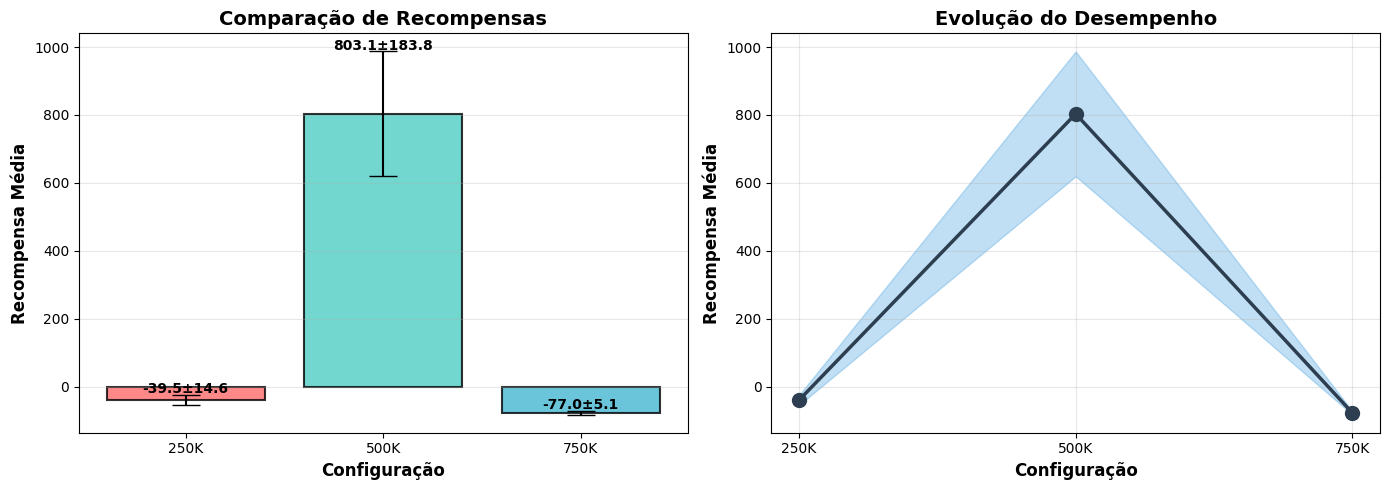

✓ Gráfico salvo: comparison_plot.png


In [6]:
# Gráfico de comparação
configs = []
means = []
stds = []

for config, data in sorted(results.items()):
    configs.append(config)
    means.append(data['avg_reward'])
    stds.append(data['std_reward'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
x_pos = np.arange(len(configs))
ax1.bar(x_pos, means, yerr=stds, capsize=10,
        color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
        edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Configuração', fontsize=12, fontweight='bold')
ax1.set_ylabel('Recompensa Média', fontsize=12, fontweight='bold')
ax1.set_title('Comparação de Recompensas', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(configs)
ax1.grid(axis='y', alpha=0.3)

for i, (mean, std) in enumerate(zip(means, stds)):
    ax1.text(i, mean + std + 5, f'{mean:.1f}±{std:.1f}',
            ha='center', fontsize=10, fontweight='bold')

# Gráfico de linha
ax2.plot(configs, means, marker='o', linewidth=2.5,
        markersize=10, color='#2C3E50')
ax2.fill_between(range(len(configs)),
                 [m - s for m, s in zip(means, stds)],
                 [m + s for m, s in zip(means, stds)],
                 alpha=0.3, color='#3498DB')
ax2.set_xlabel('Configuração', fontsize=12, fontweight='bold')
ax2.set_ylabel('Recompensa Média', fontsize=12, fontweight='bold')
ax2.set_title('Evolução do Desempenho', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(configs)))
ax2.set_xticklabels(configs)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo: comparison_plot.png")

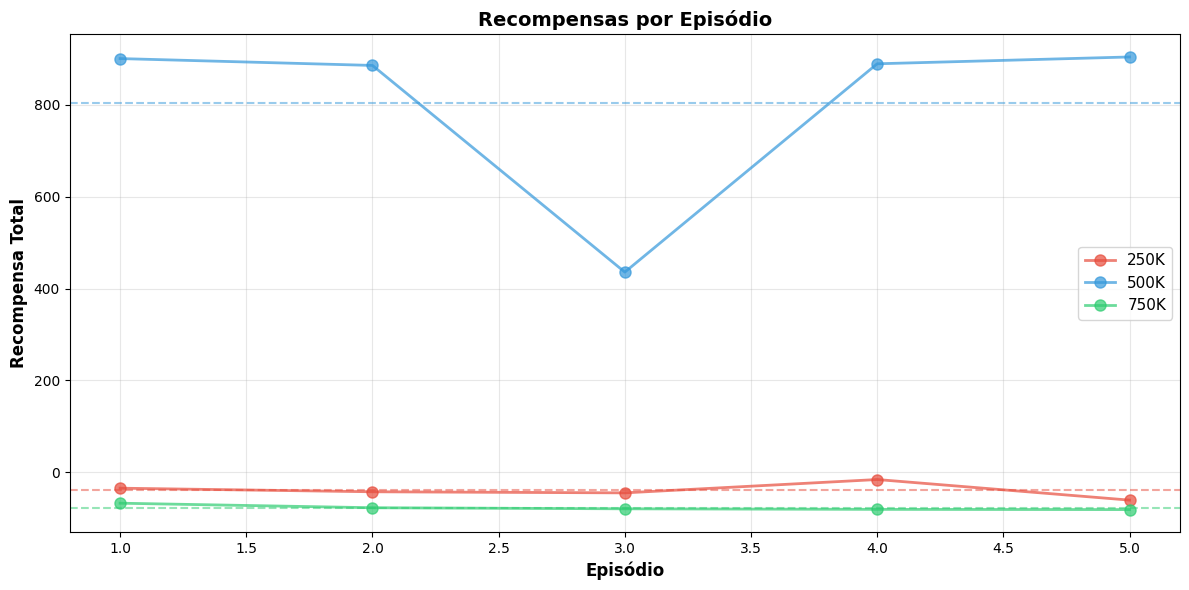

✓ Gráfico salvo: episode_rewards.png


In [7]:
# Gráfico de recompensas por episódio
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#E74C3C', '#3498DB', '#2ECC71']

for idx, (config, data) in enumerate(sorted(results.items())):
    rewards = data['eval_rewards']
    episodes = range(1, len(rewards) + 1)
    
    ax.plot(episodes, rewards, marker='o', linewidth=2,
           markersize=8, label=config, color=colors[idx], alpha=0.7)
    
    ax.axhline(y=data['avg_reward'], color=colors[idx],
              linestyle='--', linewidth=1.5, alpha=0.5)

ax.set_xlabel('Episódio', fontsize=12, fontweight='bold')
ax.set_ylabel('Recompensa Total', fontsize=12, fontweight='bold')
ax.set_title('Recompensas por Episódio', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('episode_rewards.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo: episode_rewards.png")

## 6. Análise de Melhoria

In [8]:
configs = sorted(results.keys())

print("\n" + "="*60)
print("ANÁLISE DE MELHORIA ENTRE CONFIGURAÇÕES")
print("="*60 + "\n")

for i in range(len(configs) - 1):
    current = configs[i]
    next_config = configs[i + 1]
    
    current_reward = results[current]['avg_reward']
    next_reward = results[next_config]['avg_reward']
    
    improvement = ((next_reward - current_reward) / abs(current_reward)) * 100
    
    print(f"{current} → {next_config}:")
    print(f"  Recompensa: {current_reward:.2f} → {next_reward:.2f}")
    print(f"  Melhoria: {improvement:+.2f}%")
    print(f"  Ganho absoluto: {next_reward - current_reward:+.2f}\n")

# Melhoria total
first_reward = results[configs[0]]['avg_reward']
last_reward = results[configs[-1]]['avg_reward']
total_improvement = ((last_reward - first_reward) / abs(first_reward)) * 100

print(f"Melhoria Total ({configs[0]} → {configs[-1]}):")
print(f"  {total_improvement:+.2f}%")
print(f"  Ganho absoluto: {last_reward - first_reward:+.2f}")
print("="*60 + "\n")


ANÁLISE DE MELHORIA ENTRE CONFIGURAÇÕES

250K → 500K:
  Recompensa: -39.45 → 803.09
  Melhoria: +2135.69%
  Ganho absoluto: +842.54

500K → 750K:
  Recompensa: 803.09 → -76.98
  Melhoria: -109.59%
  Ganho absoluto: -880.07

Melhoria Total (250K → 750K):
  -95.14%
  Ganho absoluto: -37.53



## 7. Teste de um Modelo Específico (Opcional)

Use esta célula para testar interativamente um modelo específico:

In [9]:
# Selecione qual modelo testar
# MODEL_TO_TEST = "750K"  # Opções: "250K", "500K", "750K"

# if MODEL_TO_TEST in results:
#    print(f"\nTestando modelo: {MODEL_TO_TEST}")
#    model_path = results[MODEL_TO_TEST]['model_path']
#    
#    # Avaliar mais episódios
#    test_rewards = evaluate_agent(model_path, num_episodes=10)
    
#    print(f"\nRecompensas dos 10 episódios: {test_rewards}")
#    print(f"Média: {np.mean(test_rewards):.2f}")
#    print(f"Desvio: {np.std(test_rewards):.2f}")
# else:
#    print(f"Modelo {MODEL_TO_TEST} não encontrado!")

## 8. Conclusão

### Arquivos Gerados:

1. **Modelos:**
   - `modelos_salvos/ppo_carracing_250K.zip`
   - `modelos_salvos/ppo_carracing_500K.zip`
   - `modelos_salvos/ppo_carracing_750K.zip`

2. **Vídeos:**
   - `videos_agentes/carracing_250K.mp4`
   - `videos_agentes/carracing_500K.mp4`
   - `videos_agentes/carracing_750K.mp4`

3. **Gráficos:**
   - `comparison_plot.png`
   - `episode_rewards.png`

4. **Logs (para TensorBoard):**
   - `logs/`

### Para visualizar os logs no TensorBoard:
```bash
tensorboard --logdir=logs/
```
